# LinkedIn Post Analysis

This notebook analyzes LinkedIn posts to identify patterns in engagement, posting frequency, and content characteristics. The insights can help optimize posting strategy and content creation.

## Setup and Data Loading

In [5]:
!pip install seaborn
!pip install pandas matplotlib seaborn numpy

In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

# Set style for better visualizations
import seaborn as sns
sns.set_theme()
sns.set_palette('deep')

# Connect to the database and load data
def load_data(db_path='../linkedin_posts.db'):
    try:
        conn = sqlite3.connect(db_path)
        df = pd.read_sql_query('SELECT * FROM posts', conn)
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        conn.close()
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

df = load_data()

# Display basic dataset information
print("Dataset Overview:")
print(f"Total posts: {len(df)}")
print(f"Date range: {df['timestamp'].min().date()} to {df['timestamp'].max().date()}")
print("\nMissing values:")
print(df.isnull().sum())

Dataset Overview:
Total posts: 1057
Date range: 2023-11-10 to 2024-11-09

Missing values:
post_id          0
profile_url      0
content          0
timestamp        0
likes            0
comments         0
has_image        0
has_video        0
media_type     609
dtype: int64


## 1. Posting Frequency Analysis

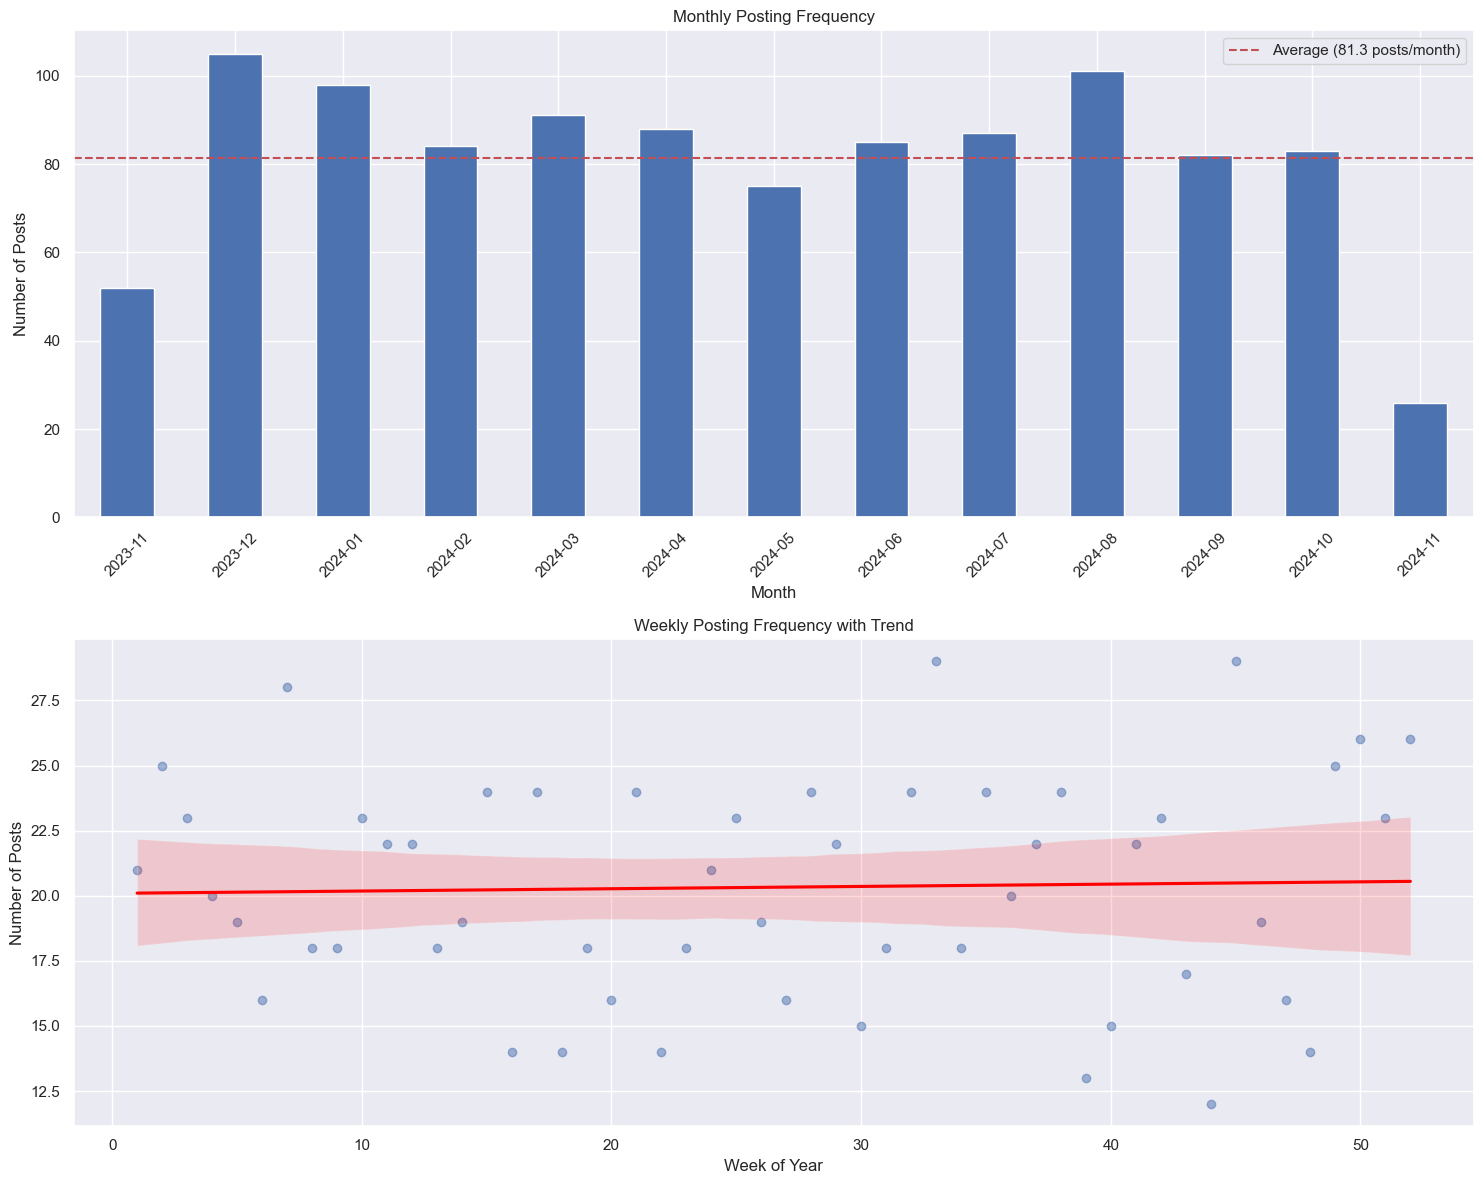

In [15]:
def analyze_posting_frequency(df):
    # Monthly frequency
    monthly_posts = df.groupby(df['timestamp'].dt.to_period('M')).size()
    avg_monthly_posts = monthly_posts.mean()
    
    # Weekly frequency
    weekly_posts = df.groupby(df['timestamp'].dt.isocalendar().week).size()
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Monthly posts plot
    monthly_posts.plot(kind='bar', ax=ax1)
    ax1.axhline(y=avg_monthly_posts, color='r', linestyle='--', 
                label=f'Average ({avg_monthly_posts:.1f} posts/month)')
    ax1.set_title('Monthly Posting Frequency')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Number of Posts')
    ax1.tick_params(axis='x', rotation=45)
    ax1.legend()
    
    # Weekly posts plot
    sns.regplot(x=weekly_posts.index, y=weekly_posts.values, 
                scatter_kws={'alpha':0.5}, line_kws={'color': 'red'}, ax=ax2)
    ax2.set_title('Weekly Posting Frequency with Trend')
    ax2.set_xlabel('Week of Year')
    ax2.set_ylabel('Number of Posts')
    
    plt.tight_layout()
    plt.show()
    
    return monthly_posts, weekly_posts

monthly_posts, weekly_posts = analyze_posting_frequency(df)

## 2. Content Analysis

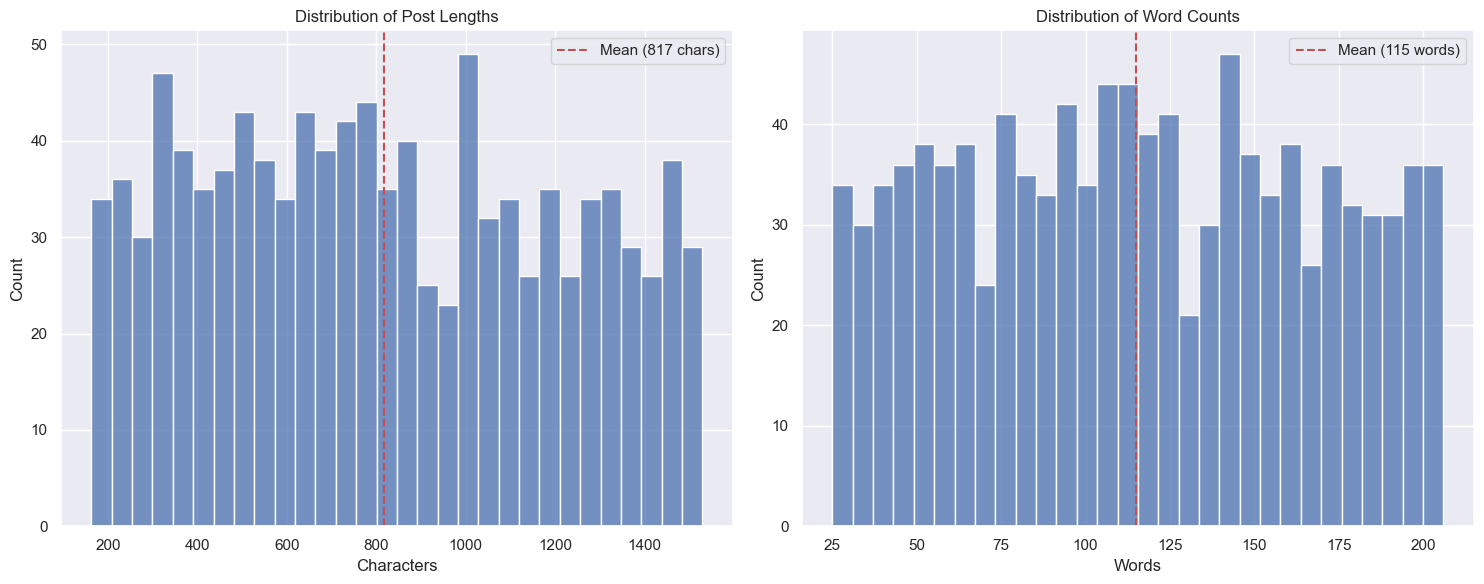

,Metric,Value
0,Average Length (chars),817
1,Average Words,115
2,Max Length,1529
3,Min Length,163


In [16]:
def analyze_content(df):
    # Calculate content metrics
    df['content_length'] = df['content'].str.len()
    df['word_count'] = df['content'].str.split().str.len()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Content length distribution
    sns.histplot(data=df, x='content_length', bins=30, ax=ax1)
    ax1.axvline(df['content_length'].mean(), color='r', linestyle='--', 
                label=f'Mean ({df["content_length"].mean():.0f} chars)')
    ax1.set_title('Distribution of Post Lengths')
    ax1.set_xlabel('Characters')
    ax1.legend()
    
    # Word count distribution
    sns.histplot(data=df, x='word_count', bins=30, ax=ax2)
    ax2.axvline(df['word_count'].mean(), color='r', linestyle='--',
                label=f'Mean ({df["word_count"].mean():.0f} words)')
    ax2.set_title('Distribution of Word Counts')
    ax2.set_xlabel('Words')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and display content statistics
    content_stats = pd.DataFrame({
        'Metric': ['Average Length (chars)', 'Average Words', 'Max Length', 'Min Length'],
        'Value': [
            f"{df['content_length'].mean():.0f}",
            f"{df['word_count'].mean():.0f}",
            f"{df['content_length'].max():.0f}",
            f"{df['content_length'].min():.0f}"
        ]
    })
    display(content_stats)

analyze_content(df)

## 3. Engagement Analysis

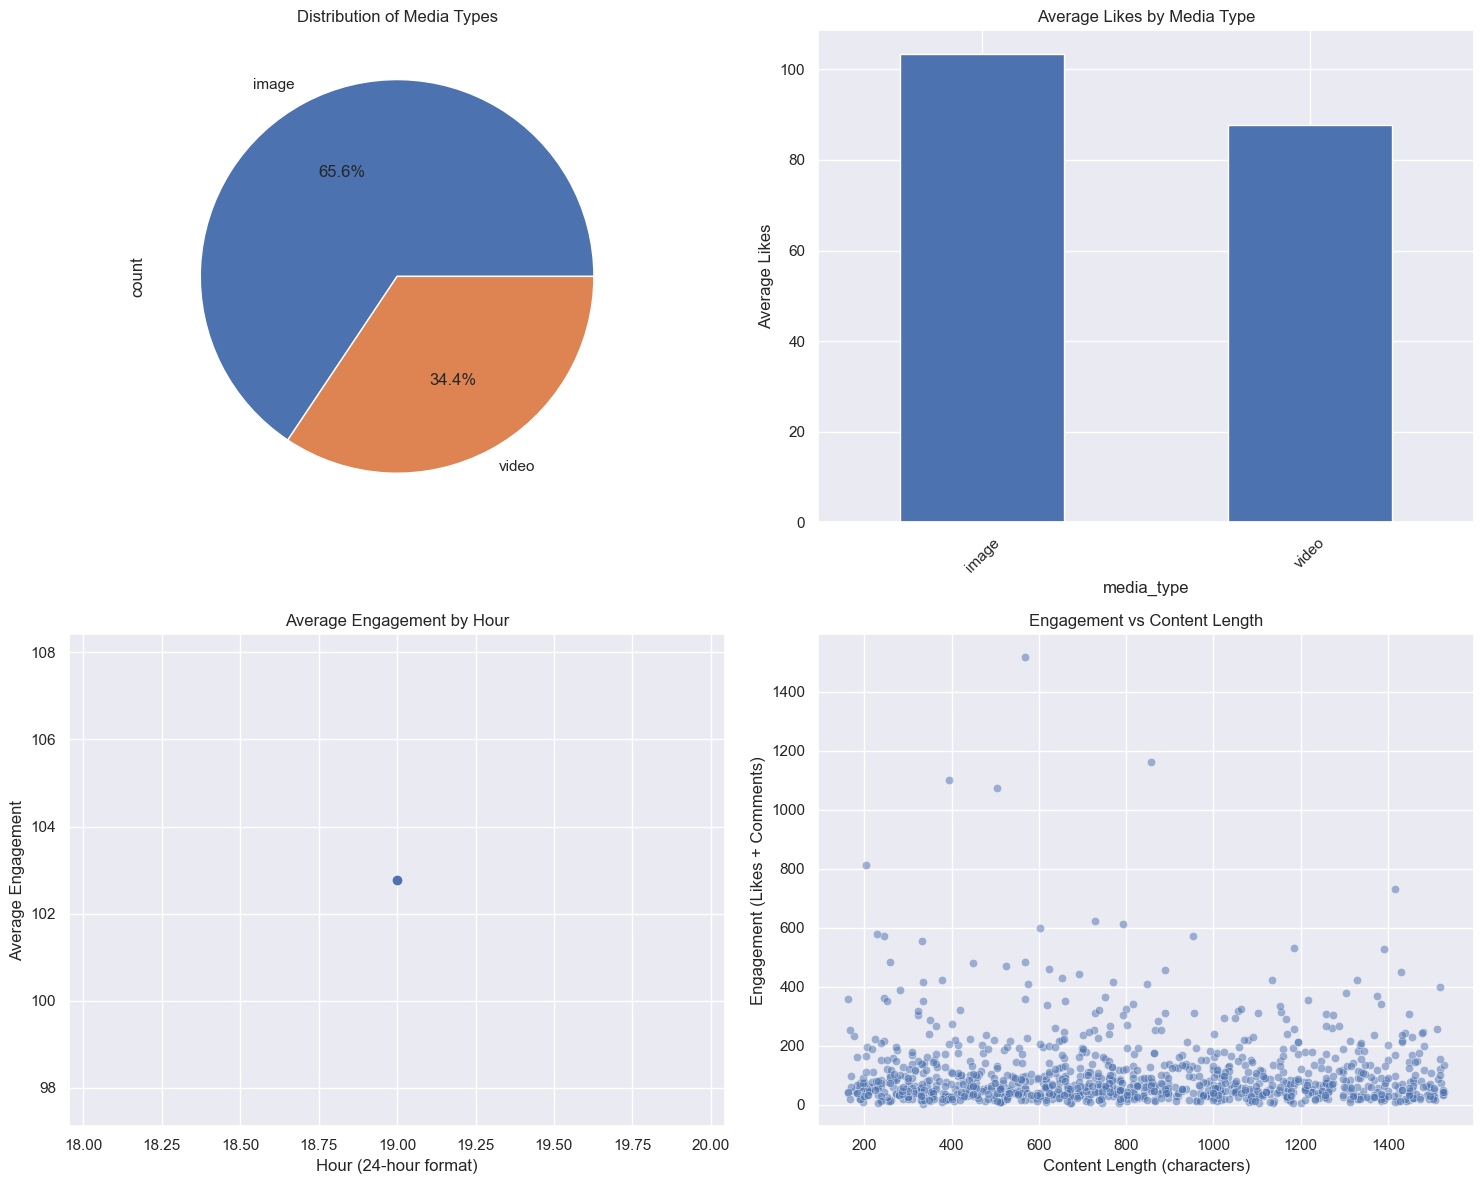

,likes,comments,engagement,count
media_type,,,,
image,103.41,11.37,114.78,294
video,87.78,11.67,99.45,154


In [17]:
def analyze_engagement(df):
    # Calculate engagement metrics
    df['engagement'] = df['likes'] + df['comments']
    df['engagement_rate'] = df['engagement'] / df['likes'].mean()  # Normalized engagement
    
    # Media type analysis
    media_metrics = df.groupby('media_type').agg({
        'likes': 'mean',
        'comments': 'mean',
        'engagement': 'mean',
        'media_type': 'count'
    }).rename(columns={'media_type': 'count'}).round(2)
    
    # Plotting
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Media type distribution
    media_counts = df['media_type'].value_counts()
    media_counts.plot(kind='pie', autopct='%1.1f%%', ax=ax1)
    ax1.set_title('Distribution of Media Types')
    
    # Average likes by media type
    media_metrics['likes'].plot(kind='bar', ax=ax2)
    ax2.set_title('Average Likes by Media Type')
    ax2.set_ylabel('Average Likes')
    ax2.tick_params(axis='x', rotation=45)
    
    # Time analysis
    hourly_engagement = df.groupby(df['timestamp'].dt.hour)['engagement'].mean()
    hourly_engagement.plot(kind='line', marker='o', ax=ax3)
    ax3.set_title('Average Engagement by Hour')
    ax3.set_xlabel('Hour (24-hour format)')
    ax3.set_ylabel('Average Engagement')
    ax3.grid(True)
    
    # Engagement correlation with content length
    sns.scatterplot(data=df, x='content_length', y='engagement', 
                    alpha=0.5, ax=ax4)
    ax4.set_title('Engagement vs Content Length')
    ax4.set_xlabel('Content Length (characters)')
    ax4.set_ylabel('Engagement (Likes + Comments)')
    
    plt.tight_layout()
    plt.show()
    
    return media_metrics

media_metrics = analyze_engagement(df)
display(media_metrics)

## 4. Key Findings and Recommendations

Based on the analysis above, here are the key insights:

1. Posting Frequency:
   - Monthly posting patterns and their consistency
   - Identification of peak posting periods

2. Content Characteristics:
   - Optimal content length range
   - Most effective content formats

3. Engagement Patterns:
   - Best performing media types
   - Optimal posting times
   - Content length vs. engagement correlation

## 5. Export Results

In [18]:
def export_results(df, monthly_posts, media_metrics, output_path='analysis_results.xlsx'):
    try:
        with pd.ExcelWriter(output_path) as writer:
            # Export monthly posting frequency
            monthly_posts.to_frame('posts').to_excel(writer, sheet_name='Monthly_Posts')
            
            # Export media type metrics
            media_metrics.to_excel(writer, sheet_name='Media_Metrics')
            
            # Export aggregated daily metrics
            daily_metrics = df.groupby(df['timestamp'].dt.date).agg({
                'likes': 'mean',
                'comments': 'mean',
                'content_length': 'mean',
                'media_type': 'count'
            }).round(2)
            daily_metrics.to_excel(writer, sheet_name='Daily_Metrics')
            
        print(f"Results exported successfully to {output_path}")
    except Exception as e:
        print(f"Error exporting results: {e}")

export_results(df, monthly_posts, media_metrics)

Results exported successfully to analysis_results.xlsx
